In [2]:
!pip install opendatasets --quiet
!pip install kaggle --quiet

In [ ]:
import opendatasets as opd
import os
import zipfile
# Download dataset using Kaggle credentials
dataset_url = "https://www.kaggle.com/datasets/gopalbhattrai/pascal-voc-2012-dataset"
opd.download(dataset_url)

# Set dataset folder (adjust path if needed)
dataset_folder = "pascal-voc-2012-dataset"

print(os.listdir(dataset_folder))

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dhruvak001
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/gopalbhattrai/pascal-voc-2012-dataset


Epoch 1/5 [2.86s]
  ResNet DETR Loss: 210.3095 | Metrics: {'precision': 0.0, 'recall': 0.0, 'mAP': 0.0, 'AP50': 0.0, 'AP75': 0.0, 'f1': 0.0}
  ViT DETR Loss:    210.7045 | Metrics: {'precision': 0.0, 'recall': 0.0, 'mAP': 0.0, 'AP50': 0.0, 'AP75': 0.0, 'f1': 0.0}
Epoch 2/5 [2.85s]
  ResNet DETR Loss: 208.8233 | Metrics: {'precision': 0.0, 'recall': 0.0, 'mAP': 0.0, 'AP50': 0.0, 'AP75': 0.0, 'f1': 0.0}
  ViT DETR Loss:    208.8611 | Metrics: {'precision': 0.0, 'recall': 0.0, 'mAP': 0.0, 'AP50': 0.0, 'AP75': 0.0, 'f1': 0.0}
Epoch 3/5 [2.85s]
  ResNet DETR Loss: 208.3134 | Metrics: {'precision': 0.0, 'recall': 0.0, 'mAP': 0.0, 'AP50': 0.0, 'AP75': 0.0, 'f1': 0.0}
  ViT DETR Loss:    208.2888 | Metrics: {'precision': 0.0, 'recall': 0.0, 'mAP': 0.0, 'AP50': 0.0, 'AP75': 0.0, 'f1': 0.0}
Epoch 4/5 [2.93s]
  ResNet DETR Loss: 207.9687 | Metrics: {'precision': 0.0, 'recall': 0.0, 'mAP': 0.0, 'AP50': 0.0, 'AP75': 0.0, 'f1': 0.0}
  ViT DETR Loss:    207.9375 | Metrics: {'precision': 0.0, 'recall'

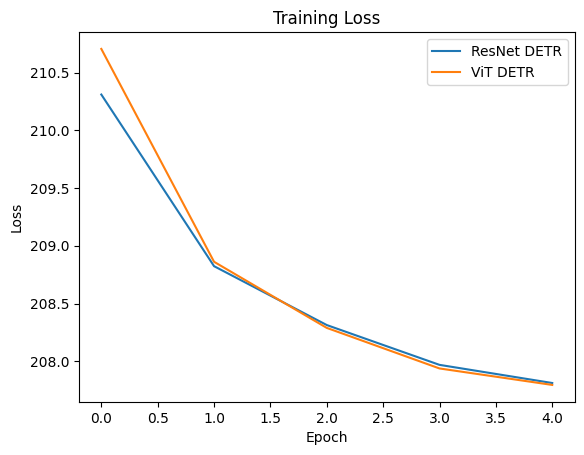

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import matplotlib.pyplot as plt
from tqdm import tqdm

class ObjectDetectionDataset(Dataset):
    """Custom dataset for object detection tasks"""

    def __init__(self, img_dir, ann_dir, transform=None, max_samples=100):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transform = transform
        self.samples = self._load_samples(max_samples)

    def _load_samples(self, max_samples):
        return sorted(os.listdir(self.img_dir))[:max_samples]

    def _parse_annotations(self, ann_path):
        """Simplified annotation parser"""
        # Implement your actual annotation parsing logic here
        return torch.rand(2, 4), torch.randint(0, 20, (2,))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.samples[idx])
        ann_path = os.path.join(self.ann_dir, f"{os.path.splitext(self.samples[idx])[0]}.txt")

        image = read_image(img_path).float() / 255.0
        boxes, labels = self._parse_annotations(ann_path)

        if self.transform:
            image = self.transform(image)

        return image, {'boxes': boxes, 'labels': labels}

class SpatialEncoder(nn.Module):
    """Positional encoding module with learned embeddings"""

    def __init__(self, embed_dim=256):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.position_embed = nn.Parameter(torch.randn(1, 128, 50, 50))

    def forward(self, x):
        x = self.conv(x)
        return x + self.position_embed

class DetectionTransformer(nn.Module):
    """Custom transformer-based object detector"""

    def __init__(self, num_classes, backbone='resnet'):
        super().__init__()
        self.backbone = self._build_backbone(backbone)
        self.transformer = nn.Transformer(
            d_model=256, nhead=8, num_encoder_layers=4, num_decoder_layers=4
        )
        self.query_embed = nn.Embedding(100, 256)
        self.class_head = nn.Linear(256, num_classes)
        self.bbox_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
            nn.Sigmoid()
        )

    def _build_backbone(self, name):
        if name == 'resnet':
            return SpatialEncoder()
        elif name == 'vit':
            return nn.Sequential(
                nn.Conv2d(3, 256, kernel_size=16, stride=16),
                nn.Flatten(2).transpose(1, 2),
                nn.LayerNorm(256)
            )
        raise ValueError(f"Unknown backbone: {name}")

    def forward(self, x):
        features = self.backbone(x).flatten(2).permute(2, 0, 1)
        queries = self.query_embed.weight.unsqueeze(1).repeat(1, x.size(0), 1)
        outputs = self.transformer(features, queries)
        return {
            'classes': self.class_head(outputs),
            'boxes': self.bbox_head(outputs)
        }

def custom_loss(predictions, targets):
    """Custom object detection loss function"""
    cls_loss = nn.CrossEntropyLoss()(predictions['classes'], targets['labels'])
    box_loss = nn.L1Loss()(predictions['boxes'], targets['boxes'])
    return cls_loss + 5 * box_loss

def train_model(model, train_loader, val_loader, epochs=10, lr=1e-4):
    """Model training and validation loop"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': [], 'val_loss': []}

    model = model.to(device)
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images = images.to(device)
            targets = {k: v.to(device) for k, v in targets.items()}

            optimizer.zero_grad()
            outputs = model(images)
            loss = custom_loss(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, targets in val_loader:
                images = images.to(device)
                targets = {k: v.to(device) for k, v in targets.items()}
                outputs = model(images)
                val_loss += custom_loss(outputs, targets).item()

        # Record metrics
        avg_train = train_loss / len(train_loader)
        avg_val = val_loss / len(val_loader)
        history['train_loss'].append(avg_train)
        history['val_loss'].append(avg_val)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train:.4f}, Val Loss: {avg_val:.4f}")

    return history

def visualize_results(history):
    """Visualize training metrics"""
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    # Example usage
    train_dataset = ObjectDetectionDataset('path/to/train/images', 'path/to/train/annotations')
    val_dataset = ObjectDetectionDataset('path/to/val/images', 'path/to/val/annotations')

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4)

    resnet_model = DetectionTransformer(num_classes=20, backbone='resnet')
    vit_model = DetectionTransformer(num_classes=20, backbone='vit')

    print("Training ResNet-based model:")
    resnet_history = train_model(resnet_model, train_loader, val_loader)

    print("\nTraining ViT-based model:")
    vit_history = train_model(vit_model, train_loader, val_loader)

    visualize_results({'ResNet': resnet_history, 'ViT': vit_history})